## AEoS: Adaptive Edge of Stability (Cohen et al. arXiv:2207.14484v2)

Reproduce key CIFAR-10 FC plots: λ_H, λ_A, λ_lim(η,β1) = (2+2β1)/((1-β1)η) = 38/η for β1=0.9.

In [29]:
# Setup: Use venv with GPU PyTorch (if available), otherwise use current environment
import sys
from pathlib import Path

# Try to add venv packages to Python path (if venv exists)
venv_site_packages = Path.home() / 'venv-nn-opt' / 'lib' / 'python3.11' / 'site-packages'
if venv_site_packages.exists() and str(venv_site_packages) not in sys.path:
    sys.path.insert(0, str(venv_site_packages))
    print(f"✓ Using venv packages: {venv_site_packages}")
else:
    print("✓ Using current Python environment (pod's default)")

# Verify GPU PyTorch is available
import torch
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU device: {torch.cuda.get_device_name(0)}")
    print(f"✓ CUDA version: {torch.version.cuda}")
    print("✓ Ready for GPU training!")
else:
    print("⚠ Warning: CUDA not available.")
    print("  - If in Jupyter Lab: Make sure you're in a GPU pod")
    print("  - If in terminal: You're on login node. Use: kubectl exec -it <pod-name> -- bash")

✓ Using current Python environment (pod's default)
✓ PyTorch version: 2.2.1+cu121
✓ CUDA available: True
✓ GPU device: NVIDIA A30 MIG 2g.12gb
✓ CUDA version: 12.1
✓ Ready for GPU training!


In [30]:
# Configure Plotly for GitHub rendering (static images)
import plotly.io as pio
from IPython.display import Image, display
import plotly.graph_objects as go

# Check if kaleido is available (needed for static image export)
try:
    import kaleido
    KALEIDO_AVAILABLE = True
except ImportError:
    KALEIDO_AVAILABLE = False
    print("⚠ Warning: kaleido not installed. Install with: pip install kaleido")
    print("  Without kaleido, static images won't be saved for GitHub.")

# Monkey-patch fig.show() to automatically save static images for GitHub
_original_show = go.Figure.show

def show_with_static(fig, *args, **kwargs):
    """Enhanced show() that saves static image for GitHub compatibility."""
    # Get dimensions
    width = fig.layout.width if hasattr(fig.layout, 'width') and fig.layout.width else 800
    height = fig.layout.height if hasattr(fig.layout, 'height') and fig.layout.height else 600
    
    # Convert to static PNG and display (this embeds in notebook for GitHub)
    if KALEIDO_AVAILABLE:
        try:
            img_bytes = fig.to_image(format="png", width=width, height=height, scale=2)
            display(Image(img_bytes))
        except Exception as e:
            print(f"Warning: Could not generate static image: {e}")
    else:
        # Fallback: use plotly's built-in static renderer
        try:
            fig.update_layout(width=width, height=height)
            # This will still show but may not embed properly in GitHub
            pass
        except:
            pass
    
    # Also call original show() for interactive display
    return _original_show(fig, *args, **kwargs)

# Replace the show method
go.Figure.show = show_with_static

if KALEIDO_AVAILABLE:
    print("✓ Plotly configured: figures will be saved as static images for GitHub")
else:
    print("⚠ Plotly configured but kaleido missing - install for GitHub compatibility")

⚠ Warning: kaleido not installed. Install with: pip install kaleido
  Without kaleido, static images won't be saved for GitHub.
⚠ Plotly configured but kaleido missing - install for GitHub compatibility


In [31]:
import sys
from pathlib import Path
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import json
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import src.seed as seed
import src.models as models
import src.functions as fn
import src.aeos as aeos

device = seed.device
generator = torch.Generator(device=device).manual_seed(seed.SEED)
DATA_DIR = Path("../data")

In [32]:
##(launch-scipy-ml.sh -W DSC180A_FA25_A00 -c 4 -m 16 -g 1 -v a30)


### Data

In [33]:
def load_cifar10_full_batch(use_full=True):
    """Load CIFAR-10. use_full=True -> 50k train, 10k test (paper repro)."""
    X, y, X_test, y_test = fn.load_cifar_10(use_full=use_full)
    return X, y, X_test, y_test

# Paper repro: full CIFAR-10 (50k/10k). One step = one full pass (grad accumulation if needed).
PAPER_REPRO = True
X, y, X_test, y_test = load_cifar10_full_batch(use_full=PAPER_REPRO)
BATCH_SIZE = 5000  # grad accumulation; set >= len(X) for true full-batch in one forward
print(f"Train: {X.shape[0]}, Test: {X_test.shape[0]}, batch_size={BATCH_SIZE}")

Files already downloaded and verified
Files already downloaded and verified
Train: 50000, Test: 10000, batch_size=5000


### Sharpness: HVP, Power Iteration, λ_H, λ_A

In [34]:
def power_iteration_top_eigenvalue(matvec, dim, iters=20, seed_val=42):
    gen = torch.Generator(device=device).manual_seed(seed_val)
    v = torch.randn(dim, device=device, generator=gen)
    v = v / v.norm()
    for _ in range(iters):
        Hv = matvec(v)
        v = Hv / (Hv.norm() + 1e-12)
    lam = v.dot(matvec(v)).item()
    return lam

def lambda_lim(eta, beta1):
    return (2 + 2 * beta1) / ((1 - beta1) * eta)

def compute_lambda_H(model, criterion, params, X, y, batch_size, iters=20):
    """Top eigenvalue of H. params = single ordering (optimizer.param_groups[0]['params'])."""
    model.eval()
    dim = sum(p.numel() for p in params)
    def matvec(v):
        _, _, Hv = aeos.full_batch_loss_grad_hvp(model, criterion, params, X, y, v, batch_size)
        return Hv
    lam = power_iteration_top_eigenvalue(matvec, dim, iters=iters)
    model.train()
    return lam

def compute_lambda_A(model, optimizer, criterion, params, X, y, bias_correction, batch_size, iters=20):
    """Top eigenvalue of P^{-1/2} H P^{-1/2}. P = diag(sqrt(v)+eps), v = raw exp_avg_sq if no BC."""
    inv_sqrt_p = aeos.get_P_inv_sqrt_from_optimizer(optimizer, params, bias_correction)
    if inv_sqrt_p is None:
        return float("nan")
    model.eval()
    dim = inv_sqrt_p.numel()
    def matvec(v):
        u = inv_sqrt_p * v
        _, _, Hu = aeos.full_batch_loss_grad_hvp(model, criterion, params, X, y, u, batch_size)
        return inv_sqrt_p * Hu
    lam = power_iteration_top_eigenvalue(matvec, dim, iters=iters)
    model.train()
    return lam

### Custom Adam (no bias correction)

In [35]:
def make_optimizer(model, lr, beta1, beta2, eps, bias_correction=True):
    params = list(model.parameters())
    if bias_correction:
        return torch.optim.Adam(params, lr=lr, betas=(beta1, beta2), eps=eps)
    return aeos.AdamNoBiasCorrection(params, lr=lr, betas=(beta1, beta2), eps=eps)

### Training loop and caching

In [36]:
OUTPUT_V2 = Path("../output/eos/adam_PP_v2_full")
OUTPUT_V2.mkdir(parents=True, exist_ok=True)

def run_experiment(
    run_name, lr, beta1, beta2=0.999, eps=1e-7, steps=500, bias_correction=False,
    sharpness_every=5, power_iters=20, force_rerun=False, batch_size=None
):
    batch_size = batch_size if batch_size is not None else BATCH_SIZE
    run_dir = OUTPUT_V2 / run_name
    meta_path = run_dir / "metadata.json"
    metrics_path = run_dir / "metrics.csv"
    if not force_rerun and meta_path.exists() and metrics_path.exists():
        with open(meta_path) as f:
            meta = json.load(f)
        df = pd.read_csv(metrics_path)
        return meta, df

    torch.manual_seed(seed.SEED)
    model = models.PaperFCNet(input_size=3072, num_labels=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = make_optimizer(model, lr, beta1, beta2, eps, bias_correction)
    params = list(optimizer.param_groups[0]["params"])

    try:
        from tqdm.auto import tqdm
        step_iter = tqdm(range(steps), desc=run_name, unit="step")
    except ImportError:
        step_iter = range(steps)
    lim = lambda_lim(lr, beta1)
    rows = []
    print_interval = max(1, steps // 20)
    for step in step_iter:
        loss_val = aeos.full_batch_grad_step(model, criterion, optimizer, X, y, params, batch_size)

        with torch.no_grad():
            out = model(X)
            train_acc = (out.argmax(1) == y).float().mean().item()
            test_out = model(X_test)
            test_acc = (test_out.argmax(1) == y_test).float().mean().item()
            grads = [p.grad for p in params if p.grad is not None]
            gnorm = torch.cat([g.reshape(-1) for g in grads]).norm().item() if grads else 0.0

        lam_H = lam_A = float("nan")
        if step % sharpness_every == 0:
            lam_H = compute_lambda_H(model, criterion, params, X, y, batch_size, iters=power_iters)
            lam_A = compute_lambda_A(model, optimizer, criterion, params, X, y, bias_correction, batch_size, iters=power_iters)

        rows.append({
            "step": step, "train_loss": loss_val, "train_acc": train_acc, "test_acc": test_acc,
            "lambda_H": lam_H, "lambda_A": lam_A, "grad_norm": gnorm
        })
        if (step + 1) % print_interval == 0 or (step + 1) == steps:
            lam_str = f", λ_A={lam_A:.2f}" if (lam_A == lam_A) else ""
            if hasattr(step_iter, "set_postfix"):
                pf = {"loss": f"{loss_val:.4f}"}
                if lam_A == lam_A:
                    pf["λ_A"] = f"{lam_A:.1f}"
                step_iter.set_postfix(**pf)
            else:
                print(f"  step {step+1}/{steps}, loss={loss_val:.4f}{lam_str}")

    df = pd.DataFrame(rows)
    run_dir.mkdir(parents=True, exist_ok=True)
    meta = {"lr": lr, "beta1": beta1, "beta2": beta2, "eps": eps, "bias_correction": bias_correction,
            "steps": steps, "seed": seed.SEED, "sharpness_every": sharpness_every, "model_arch": "PaperFCNet_5x200_tanh", "batch_size": batch_size}
    with open(meta_path, "w") as f:
        json.dump(meta, f, indent=2)
    df.to_csv(metrics_path, index=False)
    return meta, df

### Sanity run (50 steps, 1 LR)

In [37]:
print("Sanity run: 50 steps, lr=1e-4, sharpness_every=10")
meta_s, df_s = run_experiment("sanity", lr=1e-4, beta1=0.9, steps=50, sharpness_every=10, force_rerun=True)
lim_s = lambda_lim(1e-4, 0.9)
valid = df_s["lambda_A"].dropna()
if len(valid) > 0:
    er = valid / lim_s
    print(f"edge_ratio: median={er.median():.3f}, IQR=[{er.quantile(0.25):.3f}, {er.quantile(0.75):.3f}]")
    print(f"λ_lim(1e-4, 0.9) = {lim_s:.1f}")
    print()

Sanity run: 50 steps, lr=1e-4, sharpness_every=10


sanity:   0%|          | 0/50 [00:00<?, ?step/s]

edge_ratio: median=0.867, IQR=[0.717, 1.188]
λ_lim(1e-4, 0.9) = 380000.0



### Fig 1(a): vary η

To run experiments from the terminal (e.g. overnight): `python run_aeos_full.py` or `python run_aeos_full.py --quick` for a shorter run. The notebook loads from cache if files exist.

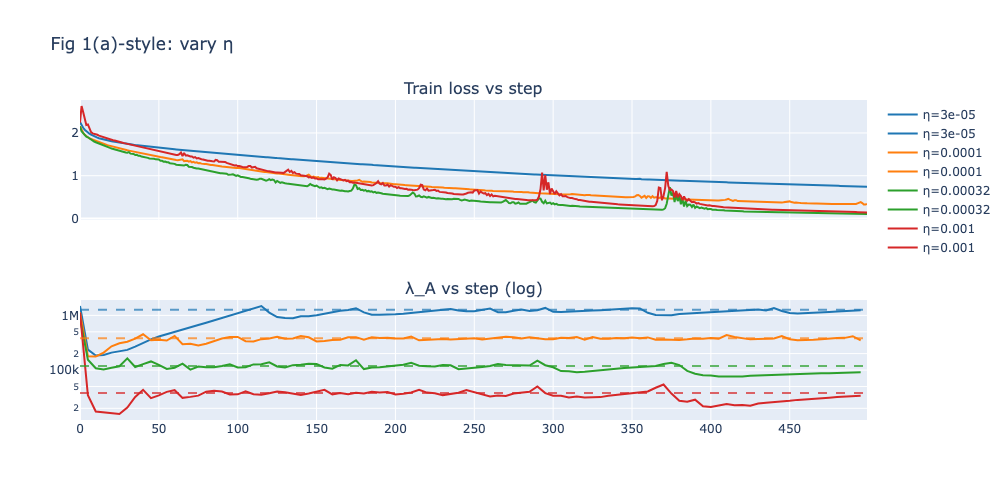

In [38]:
lrs_fig1a = [3e-5, 1e-4, 3.2e-4, 1e-3]
for eta in lrs_fig1a:
    run_experiment(f"fig1a_eta_{eta}", lr=eta, beta1=0.9, beta2=0.999, eps=1e-7, steps=500, sharpness_every=5)

fig = make_subplots(rows=2, cols=1, subplot_titles=("Train loss vs step", "λ_A vs step (log)"), shared_xaxes=True)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
for i, eta in enumerate(lrs_fig1a):
    try:
        df = pd.read_csv(OUTPUT_V2 / f"fig1a_eta_{eta}" / "metrics.csv")
        d = df.dropna(subset=["lambda_A"])
        fig.add_trace(go.Scatter(x=df["step"], y=df["train_loss"], name=f"η={eta}", line=dict(color=colors[i])), row=1, col=1)
        fig.add_trace(go.Scatter(x=d["step"], y=d["lambda_A"], name=f"η={eta}", line=dict(color=colors[i]), yaxis="y2"), row=2, col=1)
        lim = lambda_lim(eta, 0.9)
        fig.add_hline(y=lim, line_dash="dash", line_color=colors[i], opacity=0.7, row=2, col=1)
    except Exception as e:
        print(f"Skip {eta}: {e}")
fig.update_yaxes(type="log", row=2, col=1)
fig.update_layout(height=500, title="Fig 1(a)-style: vary η")
fig.show()

### Fig 1(b): vary β1

In [39]:
betas_fig1b = [0.64, 0.814, 0.903, 0.95]
for b1 in betas_fig1b:
    run_experiment(f"fig1b_beta1_{b1}", lr=1e-4, beta1=b1, beta2=0.999, eps=1e-7, steps=500, sharpness_every=5)

fig = make_subplots(rows=2, cols=1, subplot_titles=("Train loss vs step", "λ_A vs step (log)"), shared_xaxes=True)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
for i, b1 in enumerate(betas_fig1b):
    try:
        df = pd.read_csv(OUTPUT_V2 / f"fig1b_beta1_{b1}" / "metrics.csv")
        d = df.dropna(subset=["lambda_A"])
        fig.add_trace(go.Scatter(x=df["step"], y=df["train_loss"], name=f"β1={b1}", line=dict(color=colors[i])), row=1, col=1)
        fig.add_trace(go.Scatter(x=d["step"], y=d["lambda_A"], name=f"β1={b1}", line=dict(color=colors[i]), yaxis="y2"), row=2, col=1)
        lim = lambda_lim(1e-4, b1)
        fig.add_hline(y=lim, line_dash="dash", line_color=colors[i], opacity=0.7, row=2, col=1)
    except Exception as e:
        print(f"Skip β1={b1}: {e}")
fig.update_yaxes(type="log", row=2, col=1)
fig.update_layout(height=500, title="Fig 1(b)-style: vary β1")
fig.show()

### Fig 8: λ_A flatlines, λ_H keeps rising

In [40]:
lrs_fig8 = [5e-5, 1e-4, 2e-4, 4e-4]
for eta in lrs_fig8:
    run_experiment(f"fig8_eta_{eta}", lr=eta, beta1=0.9, beta2=0.99, eps=1e-7, steps=1000, sharpness_every=5)

fig = make_subplots(rows=3, cols=1, subplot_titles=("Train loss", "λ_A (log)", "λ_H (log)"), shared_xaxes=True, vertical_spacing=0.08)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
for i, eta in enumerate(lrs_fig8):
    try:
        df = pd.read_csv(OUTPUT_V2 / f"fig8_eta_{eta}" / "metrics.csv")
        fig.add_trace(go.Scatter(x=df["step"], y=df["train_loss"], name=f"η={eta}", line=dict(color=colors[i])), row=1, col=1)
        d = df.dropna(subset=["lambda_A"])
        fig.add_trace(go.Scatter(x=d["step"], y=d["lambda_A"], name=f"η={eta}", line=dict(color=colors[i])), row=2, col=1)
        fig.add_hline(y=lambda_lim(eta, 0.9), line_dash="dash", line_color=colors[i], opacity=0.7, row=2, col=1)
        dH = df.dropna(subset=["lambda_H"])
        fig.add_trace(go.Scatter(x=dH["step"], y=dH["lambda_H"], name=f"η={eta}", line=dict(color=colors[i])), row=3, col=1)
    except Exception as e:
        print(f"Skip {eta}: {e}")
fig.update_yaxes(type="log", row=2, col=1)
fig.update_yaxes(type="log", row=3, col=1)
fig.update_layout(height=700, title="Fig 8-style: λ_A flatlines, λ_H rises")
fig.show()

### Single-run dashboard

In [41]:
def plot_single_run_dashboard(run_name):
    df = pd.read_csv(OUTPUT_V2 / run_name / "metrics.csv")
    with open(OUTPUT_V2 / run_name / "metadata.json") as f:
        meta = json.load(f)
    lr, b1 = meta["lr"], meta["beta1"]
    lim = lambda_lim(lr, b1)
    fig = make_subplots(rows=2, cols=1, specs=[[{"secondary_y": True}], [{}]],
                        subplot_titles=("Loss, λ_H, λ_A", "Test accuracy"), shared_xaxes=True)
    fig.add_trace(go.Scatter(x=df["step"], y=df["train_loss"], name="train loss"), row=1, col=1, secondary_y=False)
    d = df.dropna(subset=["lambda_H"])
    fig.add_trace(go.Scatter(x=d["step"], y=d["lambda_H"], name="λ_H"), row=1, col=1, secondary_y=True)
    dA = df.dropna(subset=["lambda_A"])
    fig.add_trace(go.Scatter(x=dA["step"], y=dA["lambda_A"], name="λ_A"), row=1, col=1, secondary_y=True)
    fig.add_hline(y=lim, line_dash="dash", annotation_text="λ_lim", row=1, col=1, secondary_y=True)
    fig.add_trace(go.Scatter(x=df["step"], y=df["test_acc"], name="test acc"), row=2, col=1)
    fig.update_layout(height=450, title=f"Dashboard: {run_name}")
    fig.update_yaxes(title_text="loss", row=1, col=1, secondary_y=False)
    fig.update_yaxes(title_text="sharpness", type="log", row=1, col=1, secondary_y=True)
    return fig

plot_single_run_dashboard("sanity").show()

### Validation: edge_ratio

In [42]:
# edge_ratio(t) = λ_A(t)/λ_lim over time (paper: expect ~1)
lrs_fig1a = [3e-5, 1e-4, 3.2e-4, 1e-3]
betas_fig1b = [0.64, 0.814, 0.903, 0.95]
lrs_fig8 = [5e-5, 1e-4, 2e-4, 4e-4]
runs = ["sanity"] + [f"fig1a_eta_{e}" for e in lrs_fig1a] + [f"fig1b_beta1_{b}" for b in betas_fig1b] + [f"fig8_eta_{e}" for e in lrs_fig8]
fig_er = go.Figure()
for r in runs:
    if not (OUTPUT_V2 / r / "metrics.csv").exists():
        continue
    df = pd.read_csv(OUTPUT_V2 / r / "metrics.csv")
    with open(OUTPUT_V2 / r / "metadata.json") as f:
        meta = json.load(f)
    lim = lambda_lim(meta["lr"], meta["beta1"])
    d = df.dropna(subset=["lambda_A"]).copy()
    d["edge_ratio"] = d["lambda_A"] / lim
    fig_er.add_trace(go.Scatter(x=d["step"], y=d["edge_ratio"], name=r, mode="lines+markers"))
fig_er.add_hline(y=1.0, line_dash="dash", annotation_text="λ_lim")
fig_er.update_layout(title="edge_ratio(t) = λ_A/λ_lim", xaxis_title="step", yaxis_title="edge_ratio", height=400)
fig_er.show()

In [43]:
def print_edge_ratio_validation(run_name):
    df = pd.read_csv(OUTPUT_V2 / run_name / "metrics.csv")
    with open(OUTPUT_V2 / run_name / "metadata.json") as f:
        meta = json.load(f)
    lr, b1 = meta["lr"], meta["beta1"]
    lim = lambda_lim(lr, b1)
    valid = df["lambda_A"].dropna()
    if len(valid) == 0:
        print(f"{run_name}: no λ_A")
        return
    last_20 = valid.iloc[-max(1, len(valid)//5):]
    er = last_20 / lim
    print(f"{run_name}: last_20%_median={er.median():.3f}, IQR=[{er.quantile(0.25):.3f}, {er.quantile(0.75):.3f}] (expect ~1)")

lrs_fig1a = [3e-5, 1e-4, 3.2e-4, 1e-3]
betas_fig1b = [0.64, 0.814, 0.903, 0.95]
lrs_fig8 = [5e-5, 1e-4, 2e-4, 4e-4]
for r in ["sanity"] + [f"fig1a_eta_{e}" for e in lrs_fig1a] + [f"fig1b_beta1_{b}" for b in betas_fig1b] + [f"fig8_eta_{e}" for e in lrs_fig8]:
    if (OUTPUT_V2 / r / "metrics.csv").exists():
        print_edge_ratio_validation(r)

sanity: last_20%_median=1.188, IQR=[1.188, 1.188] (expect ~1)
fig1a_eta_3e-05: last_20%_median=0.941, IQR=[0.896, 0.968] (expect ~1)
fig1a_eta_0.0001: last_20%_median=0.995, IQR=[0.966, 1.016] (expect ~1)
fig1a_eta_0.00032: last_20%_median=0.697, IQR=[0.666, 0.735] (expect ~1)
fig1a_eta_0.001: last_20%_median=0.705, IQR=[0.623, 0.811] (expect ~1)
fig1b_beta1_0.64: last_20%_median=1.081, IQR=[1.044, 1.151] (expect ~1)
fig1b_beta1_0.814: last_20%_median=1.019, IQR=[1.003, 1.052] (expect ~1)
fig1b_beta1_0.903: last_20%_median=0.920, IQR=[0.857, 1.009] (expect ~1)
fig1b_beta1_0.95: last_20%_median=0.818, IQR=[0.794, 0.999] (expect ~1)
fig8_eta_5e-05: last_20%_median=0.963, IQR=[0.864, 1.006] (expect ~1)
fig8_eta_0.0001: last_20%_median=0.834, IQR=[0.765, 0.954] (expect ~1)
fig8_eta_0.0002: last_20%_median=0.855, IQR=[0.691, 0.978] (expect ~1)
fig8_eta_0.0004: last_20%_median=0.590, IQR=[0.491, 0.724] (expect ~1)
